## Setup

In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 455.0MB 29kB/s 
     |████████████████████████████████| 1.3MB 5.9MB/s 
     |████████████████████████████████| 5.5MB 24.6MB/s 
     |████████████████████████████████| 4.2MB 25.1MB/s 
     |████████████████████████████████| 471kB 33.2MB/s 
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021061000 which is incompatible.
  Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling keras-nightly-2.5.0.dev2021032900:
      Successfully uninstalled keras-nightly-2.5.0.dev2021032900
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics



%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


## Loading and preparing train and test data

We use "Sensors Activity Dataset" by Shoaib et al. which is available for download from [here](https://www.utwente.nl/en/eemcs/ps/research/dataset/).
There are 7 activities in this dataset: Biking, Downstairs, Jogging, Sitting, Standing, Upstairs, Walking. 
There were ten participants involved in data collection experiment who performed  each of these activities for 3-4 minutes.
All ten participants were male, between the ages of 25 and 30. 
Each of these participants was equipped with five smartphones on five body positions: 

1. One in their right jean’s pocket. 
2. One in their left jean’s pocket.
3. One on belt position towards the right leg using a belt clipper.
4. One on the right upper arm. 
5. One on the right wrist.

The data was collected for an accelerometer, a gyroscope, a magnetometer, and a linear acceleration sensor. 
Each csv file contains data for each participant's seven physical activities for all five positions. 

Notation in these files: 

Accelerometer ( Ax = x-axis, Ay = y-axis, Az= Z-aixs)   
Linear Acceleration Sensor ( Lx = x-axis, Ly = y axis, Lz= Z-aixs)   
Gyroscope ( Gx = x-axis, Gy = y-axis, Gz= Z-aixs)   
Magnetometer ( Mx = x-axis, My = y-axis, Mz= Z-aixs) 

In [ ]:
# Download dataset
! wget https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar -P ../data/

# Extract dataset using unrar
!pip install unrar
!unrar e ../data/sensors-activity-recognition-dataset-shoaib.rar ../data/

--2021-06-17 09:23:15--  https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar
Resolving www.utwente.nl (www.utwente.nl)... 130.89.3.249, 2001:67c:2564:a102::1:1
Connecting to www.utwente.nl (www.utwente.nl)|130.89.3.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100080442 (95M) [application/x-rar-compressed]
Saving to: ‘../data/sensors-activity-recognition-dataset-shoaib.rar’

sensors-activity-re 100%[===================>]  95.44M  10.7MB/s    in 11s     

2021-06-17 09:23:27 (8.92 MB/s) - ‘../data/sensors-activity-recognition-dataset-shoaib.rar’ saved [100080442/100080442]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ../data/sensors-activity-recognition-dataset-shoaib.rar

Extracting  ../data/Participant_1.csv                                      0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10%  OK 
Extracting  ../data/Particip

## Loading and preparing train and test data

We load all 10 participants data into a single dataframe:


In [ ]:
df = pd.DataFrame()
for i in range(10):
    df_tmp = pd.read_csv('../data/Participant_' + str(i+1) + '.csv', header=1)
    df = pd.concat([df, df_tmp])

# View top 5 rows of dataframe
df.head()

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,12.72,40.74,-6.00,NaN,1.390000e+12,-1.19860,-13.852,3.7865,-1.76980,-4.0625,3.89850,-3.6255,1.07390,0.13622,18.84,55.92,-6.72,NaN,1.390000e+12,0.17706,-10.569,1.8251,-7.5051,-4.7736,-0.062476,-0.36652,1.27060,-0.52412,-30.30,31.08,3.96,NaN,1.390000e+12,2.79220,-12.5720,-4.3177,-0.098712,-3.385700,-2.46480,0.021075,1.02990,1.22690,-18.72,31.74,17.82,NaN,1.390000e+12,4.3177,-2.36990,-0.43585,-5.3574,-0.95749,0.318860,0.52565,-0.18815,0.285880,-22.20,6.48,4.56,walking
1,1.390000e+12,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,12.54,40.74,-6.78,NaN,1.390000e+12,-2.38360,-16.590,2.9965,-2.70250,-6.7890,2.86820,-3.4899,0.39034,0.40073,18.60,55.86,-6.06,NaN,1.390000e+12,0.16344,-12.190,2.0703,-7.3573,-6.2618,-0.042442,-0.54459,1.28070,0.34025,-31.02,29.88,3.36,NaN,1.390000e+12,2.38360,-10.9920,-4.6037,-0.404440,-1.774500,-2.74830,0.201890,0.53573,1.32280,-18.84,31.74,17.70,NaN,1.390000e+12,5.1213,-2.19290,-0.70826,-4.5352,-0.67629,0.081656,0.43616,0.16371,0.198230,-21.90,7.14,5.34,walking
2,1.390000e+12,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,12.42,40.68,-8.10,NaN,1.390000e+12,-4.63090,-16.603,2.0703,-4.34550,-6.8081,1.68890,-3.3851,-1.99200,1.12280,18.72,55.80,-4.26,NaN,1.390000e+12,0.57205,-12.626,2.2474,-6.7655,-6.5138,0.017921,-0.70952,1.15820,0.99724,-31.26,29.22,3.24,NaN,1.390000e+12,1.56630,-9.0848,-4.5764,-1.003600,0.201530,-2.75150,0.287720,0.10049,1.20710,-19.02,31.68,17.52,NaN,1.390000e+12,5.6116,-2.12480,-1.26670,-4.0408,-0.55974,-0.523690,0.32284,0.43127,0.211970,-21.60,7.50,5.64,walking
3,1.390000e+12,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,12.30,40.74,-8.52,NaN,1.390000e+12,-4.78070,-16.453,1.1577,-4.19540,-6.6731,0.74084,-3.1017,-3.04390,0.79138,18.84,55.62,-3.12,NaN,1.390000e+12,1.21220,-12.476,2.2882,-5.9716,-6.1990,0.016760,-0.78191,1.10200,1.33380,-31.44,28.80,3.24,NaN,1.390000e+12,-0.61292,-8.5263,-2.9284,-2.827100,0.859490,-1.14670,0.175930,-0.21441,0.90469,-18.96,31.86,17.22,NaN,1.390000e+12,6.0611,-1.47100,-2.47890,-3.5908,0.15795,-1.880200,0.20403,0.72846,0.164930,-21.12,8.40,6.12,walking
4,1.390000e+12,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.24,40.80,-8.88,NaN,1.390000e+12,-0.92618,-12.190,-1.0624,-0.18116,-2.4144,-1.28500,-2.7587,-4.46020,0.69364,19.38,55.44,-0.84,NaN,1.390000e+12,2.24740,-11.387,1.9886,-4.6603,-4.8230,-0.329740,-0.82436,0.90561,2.15600,-31.56,28.32,3.30,NaN,1.390000e+12,-1.18500,-9.3436,-2.2337,-3.209900,0.085583,-0.45569,-0.033292,-0.48625,0.60720,-18.84,32.10,17.04,NaN,1.390000e+12,7.7091,-0.77636,-3.54130,-1.9450,0.85796,-2.995300,0.09896,0.94379,0.064752,-20.94,8.70,6.30,walking


In [ ]:
df.head(1)

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-1.8115,-14.873,-1.3484,-1.2691,-5.1057,-0.66445,-0.53206,-3.1869,0.23976,12.72,40.74,-6.0,NaN,1.390000e+12,-1.1986,-13.852,3.7865,-1.7698,-4.0625,3.8985,-3.6255,1.0739,0.13622,18.84,55.92,-6.72,NaN,1.390000e+12,0.17706,-10.569,1.8251,-7.5051,-4.7736,-0.062476,-0.36652,1.2706,-0.52412,-30.3,31.08,3.96,NaN,1.390000e+12,2.7922,-12.572,-4.3177,-0.098712,-3.3857,-2.4648,0.021075,1.0299,1.2269,-18.72,31.74,17.82,NaN,1.390000e+12,4.3177,-2.3699,-0.43585,-5.3574,-0.95749,0.31886,0.52565,-0.18815,0.28588,-22.2,6.48,4.56,walking


Now we split data into train and test sets (80% train, 20% test):


In [ ]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train spamples: ", len(train_data))
print("Number of test spamples: ", len(test_data))

Number of train spamples:  504000
Number of test spamples:  126000


As we only use right pocket's and left pocket's data, we should concatenate those into a single data frame:

In [ ]:
def concat(data):
    
    # Select left pocket data
    left_pocket = data.iloc[:,1:10]
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    left_pocket["MA"] = np.sqrt(np.square(left_pocket['Ax']) + np.square(left_pocket['Ay']) + np.square(left_pocket['Az']))
    left_pocket["ML"] = np.sqrt(np.square(left_pocket['Lx']) + np.square(left_pocket['Ly']) + np.square(left_pocket['Lz']))
    left_pocket["MG"] = np.sqrt(np.square(left_pocket['Gx']) + np.square(left_pocket['Gy']) + np.square(left_pocket['Gz']))
    

    # Select right pocket data
    right_pocket = data.iloc[:,15:24]
    right_pocket.columns=['Ax', 'Ay', 'Az', 'Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz']
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    right_pocket["MA"] = np.sqrt(np.square(right_pocket['Ax']) + np.square(right_pocket['Ay']) + np.square(right_pocket['Az']))
    right_pocket["ML"] = np.sqrt(np.square(right_pocket['Lx']) + np.square(right_pocket['Ly']) + np.square(right_pocket['Lz']))
    right_pocket["MG"] = np.sqrt(np.square(right_pocket['Gx']) + np.square(right_pocket['Gy']) + np.square(right_pocket['Gz']))

    
    # Extract labels 
    labels = data.iloc[:, 69] 
    labels = labels.to_frame()
    labels.columns=['Activity_Label']
    labels = pd.concat([labels]*2, ignore_index=True)
    #replace typo 'upsatirs' with upstairs! 
    labels.loc[(labels['Activity_Label'] == 'upsatirs')] = 'upstairs'
    
    #Concatenate left pocket and right pocket data into a single data frame (we only use left pocket and right pocket data)
    frames = [left_pocket, right_pocket]
    df = pd.concat(frames)
   
    return df, labels

# Generate input data and labels
train_X, train_y = concat(train_data)
test_X, test_y = concat(test_data)

In [ ]:
train_X.head(5)

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,MA,ML,MG
0,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,15.043465,5.302856,3.239893
1,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,14.097451,4.357177,1.859419
2,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,14.744242,4.971531,1.127458
3,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,13.321392,3.890337,2.600991
4,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.133143,2.595286,2.874913


In [ ]:
train_y.head()

,Activity_Label
0,walking
1,walking
2,walking
3,walking
4,walking


Next we use sliding window mechanism to generate data segments.
We use Accelerometer, Linear acceleration and Gyroscope features and their sum of squares roots:


In [ ]:
N_TIME_STEPS = 100 #sliding window length
STEP = 50 #Sliding window step size
N_FEATURES = 12 

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['Ax'].values[i: i + n_time_steps]
        ay = x['Ay'].values[i: i + n_time_steps]
        az = x['Az'].values[i: i + n_time_steps]

        lx = x['Lx'].values[i: i + n_time_steps]
        ly = x['Ly'].values[i: i + n_time_steps]
        lz = x['Lz'].values[i: i + n_time_steps]
        
        gx = x['Gx'].values[i: i + n_time_steps]
        gy = x['Gy'].values[i: i + n_time_steps]
        gz = x['Gz'].values[i: i + n_time_steps]

        MA = x['MA'].values[i: i + n_time_steps]
        ML = x['ML'].values[i: i + n_time_steps]
        MG = x['MG'].values[i: i + n_time_steps]
       
        label = stats.mode(y['Activity_Label'][i: i + n_time_steps])[0][0]
        segments.append([ax, ay, az, lx, ly, lz, gx, gy, gz, MA, ML, MG])
        labels.append(label)
        
    return segments, labels

train_X_seq, train_y_seq = generate_sequence(train_X, train_y, N_TIME_STEPS, STEP)
test_X_seq, test_y_seq = generate_sequence(test_X, test_y, N_TIME_STEPS, STEP)

In [ ]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = []
    x_temp = np.asarray(x, dtype=np.float32)
    for temp in x_temp:
      x_reshaped.append(temp.transpose())

    x_reshaped = np.asarray(x_reshaped, dtype = np.float32)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X_seq, train_y_seq, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X_seq, test_y_seq, N_TIME_STEPS, N_FEATURES)

In [ ]:
X_train[0]

array([[ -1.8115   , -14.873    ,  -1.3484   , ...,  15.043466 ,
          5.302856 ,   3.2398927],
       [  0.24517  , -14.07     ,  -0.84446  , ...,  14.097451 ,
          4.357177 ,   1.8594185],
       [ -0.57205  , -14.628    ,  -1.757    , ...,  14.744242 ,
          4.971531 ,   1.1274583],
       ...,
       [  1.3893   ,  -7.355    ,  -0.42223  , ...,   7.496963 ,
          2.6530466,   2.8563182],
       [  0.35413  ,  -7.7772   ,   0.36775  , ...,   7.793939 ,
          2.1102092,   3.3793929],
       [  0.7355   ,  -7.9543   ,   0.35413  , ...,   7.9960775,
          1.8348402,   3.224824 ]], dtype=float32)

In [ ]:
X_test.shape

(5038, 100, 12)

## Building the model

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten, BatchNormalization
from keras.layers import Input
from keras import optimizers

N_CLASSES = 7
N_HIDDEN_UNITS = 64
L2 = 0.000001

model = Sequential([
    LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
        kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
        bias_regularizer=l2(L2), name="LSTM_1"),
    Flatten(name='Flatten'),
    Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 100, 64)           19712     
_________________________________________________________________
Flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
Dense_2 (Dense)              (None, 7)                 44807     
Total params: 64,519
Trainable params: 64,519
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluation

In [ ]:
opt = optimizers.Adam(lr=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
BATCH_SIZE = 1024
N_EPOCHS = 10

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=N_EPOCHS,
                    validation_data=(X_test, y_test))


Epoch 1/10
20/20 [==============================] - 32s 693ms/step - loss: 1.8208 - accuracy: 0.3492 - val_loss: 1.2837 - val_accuracy: 0.6046
Epoch 2/10
20/20 [==============================] - 13s 640ms/step - loss: 1.0603 - accuracy: 0.7266 - val_loss: 0.8578 - val_accuracy: 0.7441
Epoch 3/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6808 - accuracy: 0.8284 - val_loss: 0.6269 - val_accuracy: 0.8178
Epoch 4/10
20/20 [==============================] - 13s 635ms/step - loss: 0.4797 - accuracy: 0.8994 - val_loss: 0.4886 - val_accuracy: 0.8545
Epoch 5/10
20/20 [==============================] - 13s 631ms/step - loss: 0.3472 - accuracy: 0.9279 - val_loss: 0.3915 - val_accuracy: 0.8811
Epoch 6/10
20/20 [==============================] - 13s 638ms/step - loss: 0.2602 - accuracy: 0.9463 - val_loss: 0.3214 - val_accuracy: 0.9039
Epoch 7/10
20/20 [==============================] - 13s 642ms/step - loss: 0.1898 - accuracy: 0.9610 - val_loss: 0.2482 - val_accuracy: 0.9381

In [ ]:
# tf.random.set_seed(42)
# batch_size_list = [128, 256, 512, 1024]
# hidden_layer_list = [8, 16, 32, 64]
# lr_list = [1, 0.1, 0.01, 0.001, 0.0001]
# accuracy_list = []

# for num in lr_list:
#   LR = num
#   N_HIDDEN_UNITS = 64
#   model = Sequential([
#       LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2), bias_regularizer=l2(L2), name="LSTM_1"),
#       Flatten(name='Flatten'),
#       Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"),
#       Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
#   ])
#   opt = optimizers.Adam(lr=LR)
#   model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#   BATCH_SIZE = 256
#   history = model.fit(X_train, y_train,
#                     batch_size=BATCH_SIZE, epochs=N_EPOCHS,
#                     validation_data=(X_test, y_test))
#   accuracy_list.append(history.history['accuracy'])

# plt.plot(accuracy_list[0], label='128')
# plt.plot(accuracy_list[1], label='256')
# plt.plot(accuracy_list[2], label='512')
# plt.plot(accuracy_list[3], label='1024')

# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')
# plt.title('Accuracy depends on hidden layers')
# plt.legend()
# plt.show();

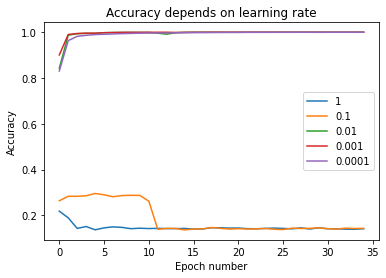

In [ ]:
# plt.plot(accuracy_list[0], label='1')
# plt.plot(accuracy_list[1], label='0.1')
# plt.plot(accuracy_list[2], label='0.01')
# plt.plot(accuracy_list[3], label='0.001')
# plt.plot(accuracy_list[4], label='0.0001')

# plt.xlabel('Epoch number')
# plt.ylabel('Accuracy')
# plt.title('Accuracy depends on learning rate')
# plt.legend()
# plt.show();

In [ ]:
# from numpy import mean
# from numpy import std

# #evaluation
# def evaluate_model():
#   N_CLASSES = 7
#   N_HIDDEN_UNITS = 64
#   L2 = 0.000001

#   model = Sequential([
#       LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
#           kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#           bias_regularizer=l2(L2), name="LSTM_1"),
#       Flatten(name='Flatten'),
#       Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
#   ])
#   opt = optimizers.Adam(lr=0.0001)

#   model.compile(optimizer=opt,
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
#   BATCH_SIZE = 1024
#   N_EPOCHS = 10

#   history = model.fit(X_train, y_train,
#                       batch_size=BATCH_SIZE, epochs=N_EPOCHS,
#                       validation_data=(X_test, y_test))
#   _, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
#   return accuracy

# # summarize scores
# def summarize_results(scores):
# 	print(scores)
# 	m, s = mean(scores), std(scores)
# 	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# # run an experiment
# def run_experiment(repeats=10):
# 	# repeat experiment
# 	scores = list()
# 	for r in range(repeats):
# 		score = evaluate_model()
# 		score = score * 100.0
# 		print('>#%d: %.3f' % (r+1, score))
# 		scores.append(score)
# 	# summarize results
# 	summarize_results(scores)

In [ ]:
# # run the experiment
# run_experiment()

Epoch 1/10
20/20 [==============================] - 16s 711ms/step - loss: 1.6799 - accuracy: 0.3647 - val_loss: 1.1884 - val_accuracy: 0.6840
Epoch 2/10
20/20 [==============================] - 13s 667ms/step - loss: 1.0064 - accuracy: 0.7533 - val_loss: 0.8169 - val_accuracy: 0.7948
Epoch 3/10
20/20 [==============================] - 13s 671ms/step - loss: 0.6761 - accuracy: 0.8477 - val_loss: 0.6096 - val_accuracy: 0.8392
Epoch 4/10
20/20 [==============================] - 13s 669ms/step - loss: 0.4862 - accuracy: 0.9011 - val_loss: 0.4794 - val_accuracy: 0.8666
Epoch 5/10
20/20 [==============================] - 14s 678ms/step - loss: 0.3583 - accuracy: 0.9318 - val_loss: 0.3858 - val_accuracy: 0.8873
Epoch 6/10
20/20 [==============================] - 13s 672ms/step - loss: 0.2658 - accuracy: 0.9496 - val_loss: 0.3111 - val_accuracy: 0.9085
Epoch 7/10
20/20 [==============================] - 13s 673ms/step - loss: 0.1974 - accuracy: 0.9606 - val_loss: 0.2546 - val_accuracy: 0.9345

## Confusion Matrix

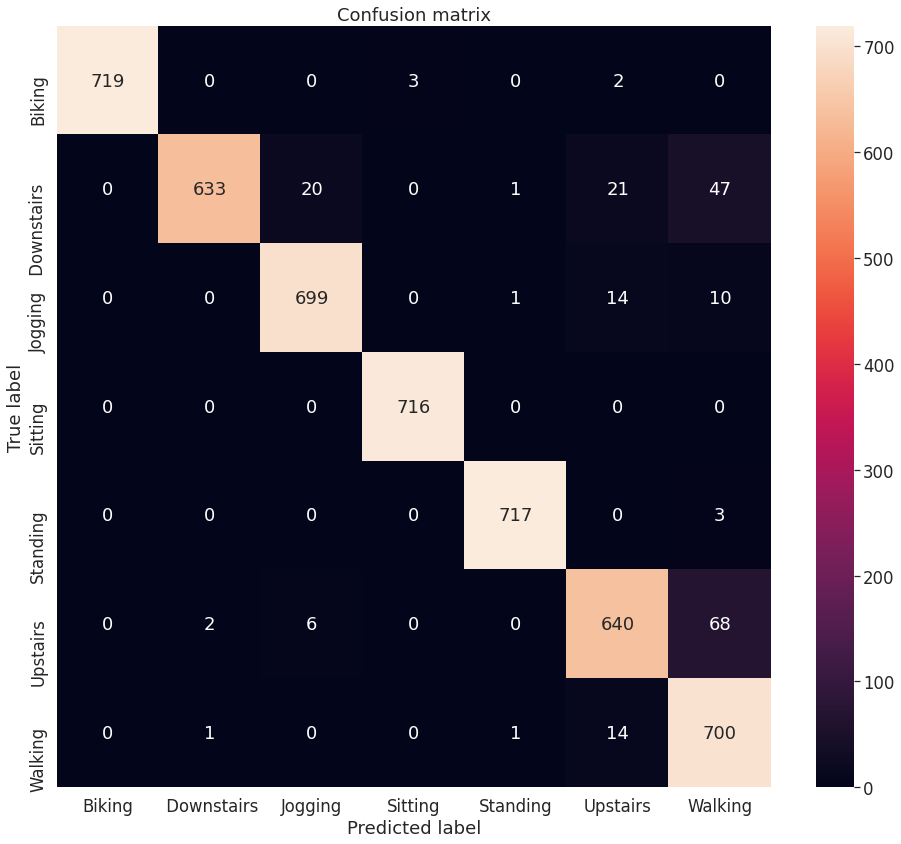

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Biking' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();


In [ ]:
print(f1_score(y_true_labels, y_pred_labels, average='micro'))

0.964271536323938


## Exporting the model 

Finally we export the trained model in a format which easily can be used in our android application for on-device inference. The exported model will be named "frozen_HAR.pb" and be stored under models directory:

In [ ]:
# from keras import backend as K
# from tensorflow.python.tools import freeze_graph
# from tensorflow.python.tools import optimize_for_inference_lib

# input_node_names= ["LSTM_1_input"]
# output_node_name = "Dense_2/Softmax"
# MODEL_NAME = "HAR"

# tf.train.write_graph(K.get_session().graph_def, 'models', \
#         MODEL_NAME + '_graph.pbtxt')
# saver = tf.train.Saver()
# saver.save(K.get_session(), 'models/' + MODEL_NAME + '.chkp')

# freeze_graph.freeze_graph('models/' + MODEL_NAME + '_graph.pbtxt', None, \
#     False, 'models/' + MODEL_NAME + '.chkp', output_node_name, \
#     "save/restore_all", "save/Const:0", \
#     'models/frozen_' + MODEL_NAME + '.pb', True, "")

In [ ]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, N_TIME_STEPS, N_FEATURES], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: keras_lstm/assets


INFO:tensorflow:Assets written to: keras_lstm/assets


In [ ]:
# Save the model.
with open('har_tflite.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# !zip -r model.zip models

In [ ]:
# from google.colab import files
# files.download("model1.tflite")